# Square Gradient Theory for Mixtures

Square Gradient Theory allows studying the interfacial behavior of fluid. SGT proposes that the Helmholtz free energy density at the interface can be described by the sum of a homogeneous and a gradient contribution, in which the density profiles between the bulk phases are mean to minimize the energy of the system. This results in the following Euler-Lagrange system: 

$$ \sum_j c_{ij} \frac{d^2 \rho_j}{dz^2} = \mu_i - \mu_i^0 \qquad i = 1,...,c$$ 
$$ \rho(z \rightarrow -\infty) = \rho^\alpha \qquad \rho(z \rightarrow \infty) = \rho^\beta $$

Here, $z$ represents the interfacial position,  $\mu$, the chemical potential and $\rho$ the density vector. The superscript 0 refers to the bulk phase value and $\alpha$, $\beta$ to the bulk phases index. Finally, $c_{ij}$, represents the cross-influence parameter between molecule $i$ and $j$ and, in general, is computed as the geometric mean of the pure fluid's influence parameter and a correction factor:

$$ c_{ij} = (1 - \beta_{ij}) \sqrt{c_{ii} c_{jj}} $$

The solution procedure of the SGT strongly depends on whether the influence parameter matrix is singular or not. f any of the correction parameter $\beta_{ij}$ is different from zero, it is necessary to solve the Euler-Lagrange system as a boundary value problem (BVP) with a finite interfacial length. One numerical efficient method proposed by [Liang et al.](https://www.sciencedirect.com/science/article/pii/S0378381217302893) is to use orthogonal collocation which considerably reduces the grid to solve the density profiles and provides a direct route to compute interfacial tension. This is done with the ``sgt_mix`` function.

An alternative formulation proposed by [Mu et al.](https://www.sciencedirect.com/science/article/pii/S0378381216305787), to modify the SGT Euler-Lagrange system, considering a time-stabilized form.

$$ \sum_j c_{ij} \frac{d^2 \rho_j}{dz^2} = \frac{d \rho_i}{ds} +  \mu_i - \mu_i^0 \qquad i = 1,...,c $$

This approach is performed by the ``msgt_mix`` function.


Once the density profiles are solved the interfacial tension can be computed as:

$$ \sigma =  \int_{-\infty}^{\infty} \sum_i \sum_j c_{ij} \frac{d\rho_i}{dz} \frac{d\rho_j}{dz} dz $$

This notebook has the purpose of showing examples of computing interfacial tension of mixtures and $\beta_{ij} \neq 0$.

First, it's needed to import the necessary modules

In [1]:
import numpy as np
from SGTPy import component, mixture, saftvrmie
from SGTPy.equilibrium import bubblePy
from SGTPy.sgt import sgt_mix, msgt_mix
import matplotlib.pyplot as plt

Then the mixture and EoS are created. The bubble point of the mixture of x1 = 0.3 at 320K is computed. The ```full_output``` option allows obtaining the compositions, densities and equilibrium pressure.

In [2]:
ethanol = component('ethanol2C', ms = 1.7728, sigma = 3.5592 , eps = 224.50,
                    lambda_r = 11.319, lambda_a = 6., eAB = 3018.05, rcAB = 0.3547,
                    rdAB = 0.4, sites = [1,0,1], cii= 5.3141080872882285e-20)

hexane = component('hexane', ms = 1.96720036, sigma = 4.54762477, eps = 377.60127994, 
                   lambda_r = 18.41193194, cii = 3.581510586936205e-19)

mix = mixture(ethanol, hexane)
# or
mix = ethanol + hexane

kij = 0.011818492037463553
Kij = np.array([[0, kij], [kij, 0]])
mix.kij_saft(Kij)
eos = saftvrmie(mix)

T = 320 #K
X = np.array([0.3, 0.7])
P0 = 3e4 # Pa
Y0 = np.array([0.7, 0.3])

sol = bubblePy(Y0, P0, X, T, eos, full_output = True)
Y = sol.Y
P = sol.P
vl = sol.v1
vv = sol.v2

#computing the density vector
rhol = X / vl
rhov = Y / vv

In order to set the beta correction is necessary to create the matrix and then use it with the  ```beta_sgt``` method from the eos. If this step is not done the ```sgt_mix``` or ```msgt_sgt``` function will raise an error as the influence parameter matrix will be singular. 

In [3]:
bij = 0.05719272059410664
beta = np.array([[0, bij], [bij, 0]])
eos.beta_sgt(beta)

The first option is to solve the BVP iteratively using orthogonal collocation. The initial interfacial length is set to 10 Amstrong and the density profiles are solved, then the interfacial length is increased until the calculated interfacial tension doesn't change more than a given tolerance.

The initial value can be set as ```'linear'``` or ```'hyperbolic'``` to use a linear or a hyperbolic approximation. Optionally an array can be passed to the argument ```rho0``` or a TensionResult for another calculation, for example, the density profile computed with beta0 calculation.

In [4]:
sol = sgt_mix(rhol, rhov, T, P, eos, z0 = 10,  rho0 = 'linear',full_output = True)

C:\Users\Gusta\anaconda3\lib\site-packages\sgtpy-0.0.12-py3.8-win-amd64.egg\SGTPy\vrmie_mixtures\ahs_monomer.py:121: RuntimeWarning: invalid value encountered in log
  log3 = np.log(xhi3_1)
C:\Users\Gusta\anaconda3\lib\site-packages\sgtpy-0.0.12-py3.8-win-amd64.egg\SGTPy\vrmie_mixtures\ghs_chain.py:135: RuntimeWarning: invalid value encountered in log
  k0 = -np.log(xhix_1) + (42*xhix - 39*xhix2 + 9*xhix3 - 2*xhix4)/(6*xhix_13)
C:\Users\Gusta\anaconda3\lib\site-packages\sgtpy-0.0.12-py3.8-win-amd64.egg\SGTPy\vrmie_mixtures\ares.py:851: RuntimeWarning: invalid value encountered in log
  aux1 = np.log(Xass) - Xass/2 + 1/2
C:\Users\Gusta\anaconda3\lib\site-packages\sgtpy-0.0.12-py3.8-win-amd64.egg\SGTPy\vrmie_mixtures\ghs_chain.py:194: RuntimeWarning: overflow encountered in exp
  dg[0] = np.exp(dg[0])
C:\Users\Gusta\anaconda3\lib\site-packages\sgtpy-0.0.12-py3.8-win-amd64.egg\SGTPy\vrmie_mixtures\lngmie_chain.py:79: RuntimeWarning: divide by zero encountered in log
  lng = np.log(ghs) + 

In [5]:
sol.tension
sol.rho
sol.z
sol.GPT

array([0.00000000e+00, 2.45283583e-02, 6.72941392e-01, 4.04539897e+00,
       1.43956571e+01, 4.11617277e+01, 1.10109648e+02, 2.96107700e+02,
       7.88245847e+02, 1.86744039e+03, 3.40630792e+03, 4.43865227e+03,
       4.40676359e+03, 3.67018284e+03, 2.64421424e+03, 1.59690736e+03,
       7.75933825e+02, 2.98578554e+02, 8.89234878e+01, 1.70535756e+01,
       7.78005583e-01, 0.00000000e+00])

The other option is to use a modified SGT system that includes a temporal variable which helps to reach the stationary density profile ignoring the nonlinearity of the BVP at the first iterations. This type of computation uses a fixed value for the interfacial length.

The initial value options to solve the density profiles are the same as for ```sgt_mix```. In this case, the previously computed TensionResult is used as an initial guess.

In [6]:
solm = msgt_mix(rhol, rhov, T, P, eos, z = 20, rho0 = sol, full_output = True)

In [7]:
print('BVP SGT : ', sol.tension, 'mN/m')
print('Modified BVP SGT : ', solm.tension, 'mN/m')

BVP SGT :  15.060383249685296 mN/m
Modified BVP SGT :  15.060383249685296 mN/m


Finally, the density profiles can be compared. It can be seen that when a correction to the cross-influence parameter just one stationary point across the interface.

Text(0, 0.5, '$\\rho_2$ / kmol m$^{-3}$ ')

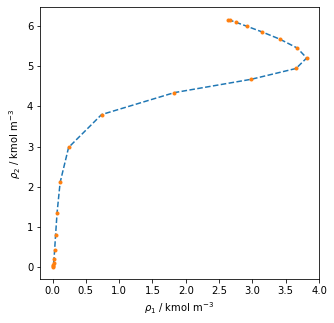

In [8]:
#convert densities to kmol/m3
rho = sol.rho / 1000
rhom = solm.rho / 1000 

fig = plt.figure(figsize = (5,5))
ax = fig.add_subplot(111)
ax.plot(rho[0], rho[1], '--')
ax.plot(rhom[0], rhom[1], '.')
ax.set_xlabel(r'$\rho_1$ / kmol m$^{-3}$ ')
ax.set_ylabel(r'$\rho_2$ / kmol m$^{-3}$ ')
# fig.savefig('sgt.jpg')

---
For further information about the ``sgt_mix`` and ``msgt_mix`` functions check out the documentation running: ``sgt_mix?`` or ``msgt_mix?``